[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook04_Introduction_to_Tensorflow.ipynb)

# Notebook 04: Introduction to Tensorflow

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.


### Primary Goal: Introduce ```tensorflow``` 

#### Background

[tensorflow](https://www.tensorflow.org/)

What is it? 
    
- A Google maintained open-source package that does all things neural networks
    
Why don't we use ```sklearn```?

- ```sklearn``` does have a multi-layer perceptron [method](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but currently there is no support for convolutional neural networks. You could use ```sklearn``` for ANNs, but  ```tensorflow``` is a bit more flexible and is commonly used in research and industry. Furthermore, tensorflow has built in GPU support, which will help accelerate training.

Where can I find more tutorials about tensorflow? 

- ```tensorflow``` has many good [tutorials](https://www.tensorflow.org/tutorials) on how to use their package. Just be aware that their datasets are not weather related (e.g., images of hand written digits, low-resolution pictures of dogs and cats and horses), so adapting their methods to meteorology examples can be challenging. 

#### Step 0: Install and grab data

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')


#### Step 1: Imports

Just like ```matplotlib.pyplot``` is abbreviated as ```plt``` and ```numpy``` is abbreviated as ```np```, ```tensorflow``` is imported as ```tf```:

In [1]:
import tensorflow as tf

#one quick thing here, we need to set the random seed so we all get the same results no matter the computer or python session 
tf.random.set_seed(42)

#### Step 2: Build a model 

The most common way to build a network is to use the model called ``` Sequential ```. This is, as the name suggests, a model that follows a list of sequential layers. So you can envision that your data will *flow* through each entry of this ```Sequential``` model. 

The pieces that make up this ```Sequential``` model come from ```tf.keras.layers``` and include dense layers (e.g., the artifical neural network node layers) and convolutional layers. 

Let's do an example. First we'll build a simple perceptron. Remember that a perceptron is a single-node network, so all we need to do is create a dense network with one node: 

In [2]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1,input_shape=(1,))])

2022-10-27 15:48:35.226722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Viola, you have your first neural network model built with tensorflow. If you want to see what you built, look at the ```.summary``` method. This will show you a nice summarized shape of the model.

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


You should see above that it shows the name of the layers, the shapes, and the number of *parameters* (i.e., weights). 

This example is very simple and is exactly linear regression in its current form. This is because by default the *activation* (remember the $\sigma$ function in the equation) is linear. So this model is just: 

$$ (w x + b) $$

where w and b are the 2 trainable parameters. The cool thing about tensorflow is that the models contain these parameters and you can see them! To view them you have to select the layer, then print out ```.weights```: 

In [4]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.5700599]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

So long as you only built the model once (i.e., ran the code once) you should see two entries above, a *kernel* and a *bias*. This is the $w$ and the $b$. For neural networks we need to randomly intialize the weights. This is because setting an initial value of 0 for all parameters does not work well for many ML tasks. Instead, intial weights are usually intialized with some random value between 0-1. 

#### Step 3: Load some data

So far, all we have is a randomly initialized model. Next we need to actually train it on some data. Let's load in the pre-engineered data for our example and fit this model to predict the number of lightning strikes from the IR brightness temperature. This is the same simple task that we demonstrated in Part 1.

In [5]:
import pandas as pd 
import numpy as np 
import tqdm 
import matplotlib
import matplotlib.pyplot as plt 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'

Text(0, 0.5, '$log_{10}(lightning flashes)$')

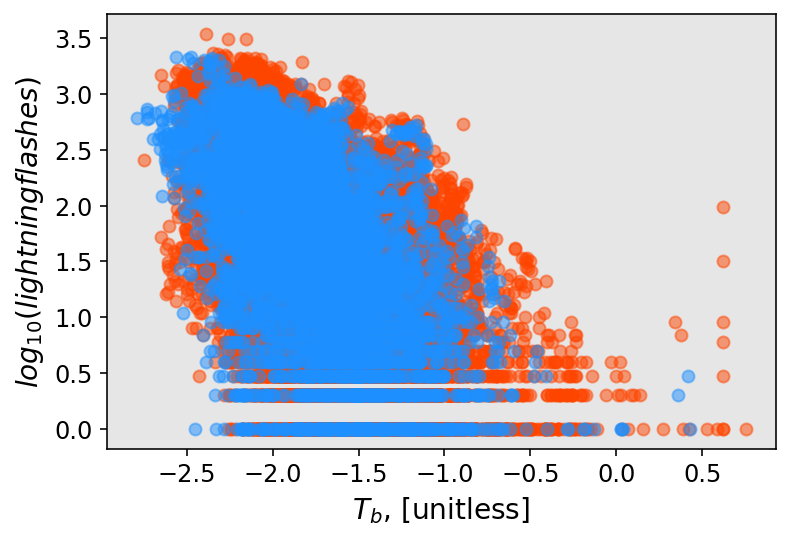

In [6]:
#load training 
df_t = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_train.csv')
#load validation set
df_v = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_val.csv')

#drop non-lightning times 
df_t = df_t.where(df_t.label_reg > 0).dropna()
df_v = df_v.where(df_v.label_reg > 0).dropna()

#grab the minimum brightness temperature for IR (```q000_ir```)
X_t = df_t.to_numpy()[:,0:1]
#take the log of y so we can get a linear regression to work 
y_t = np.log10(df_t.to_numpy()[:,37])

#do the same for the validation set 
X_v = df_v.to_numpy()[:,0:1]
y_v = np.log10(df_v.to_numpy()[:,37])

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')


Okay, everything looks correct. 

Just as a quick check, let's see how the model would perform with just the randomly initialized parameters. Let's plug in linearly spaced values in x. To get the model output, you use the ```model.predict()``` method.

Text(0, 0.5, '$log_{10}(lightning flashes)$')

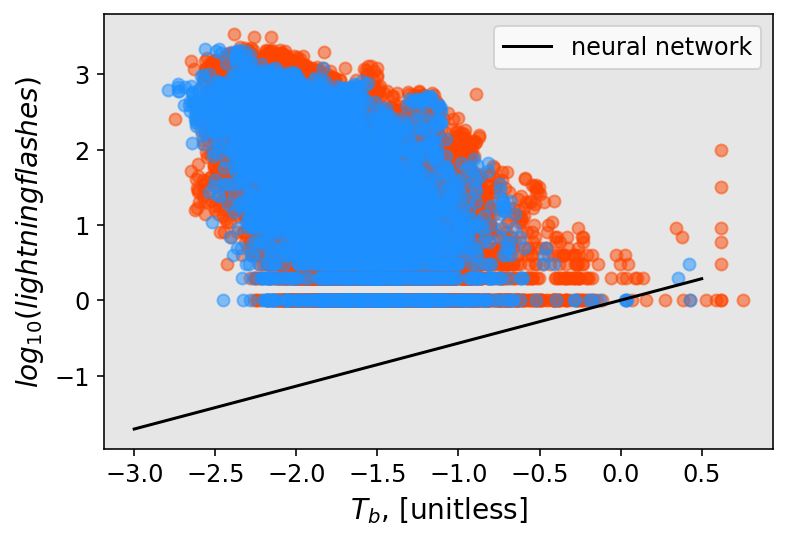

In [7]:
x = np.linspace(-3,0.5)
yhat = model.predict(x)

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.plot(x,yhat,'-k',label='neural network')
plt.legend()
plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')

It is pretty clear that the randomly initialized parameters would not work as is!  To improve this performance, we need to actually train the model!

#### Step 4: Compile model 

Before we can train our model, we need to first compile its *loss* and *optimizer*. To keep this example consistent with linear regression, we will choose the mean squarred error as the loss function and gradient descent as the optimizer.

In [8]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.SGD())

#### Step 5: Shuffle and batch 

Recall the discussion of how neural networks are trained. We train a neural network by asking the question, 'How can I change the weights such that it makes the model better?' We answer this by first calculating the gradient on a small subset of the training data (i.e., a batch), then take a small step (or change to the weights). Then another batch is fed in and the process is repeated until all data is ran through the model. 

To shuffle and batch the data, the easiest method is to use tensorflow datasets. Let's build one of those now. To do that we use the ```tf.data.Dataset.from_tensor_slices``` which will make the dataset for us:


In [9]:
ds_train = tf.data.Dataset.from_tensor_slices((X_t,y_t))

ds_train

<TensorSliceDataset shapes: ((1,), ()), types: (tf.float64, tf.float64)>

We can loop through this dataset to see each example sequentially. 

In [10]:
#just loop over the first 5 entries. 
for i,(x,y) in enumerate(ds_train):
    print(i,x,y)
    if i == 5:
        break

0 tf.Tensor([-2.19623756], shape=(1,), dtype=float64) tf.Tensor(2.7781512503836434, shape=(), dtype=float64)
1 tf.Tensor([-2.09703255], shape=(1,), dtype=float64) tf.Tensor(2.7442929831226763, shape=(), dtype=float64)
2 tf.Tensor([-2.19119954], shape=(1,), dtype=float64) tf.Tensor(2.6866362692622934, shape=(), dtype=float64)
3 tf.Tensor([-2.06990647], shape=(1,), dtype=float64) tf.Tensor(2.5514499979728753, shape=(), dtype=float64)
4 tf.Tensor([-2.03890491], shape=(1,), dtype=float64) tf.Tensor(2.6190933306267428, shape=(), dtype=float64)
5 tf.Tensor([-2.18577433], shape=(1,), dtype=float64) tf.Tensor(2.7573960287930244, shape=(), dtype=float64)


You have probably noticed the word 'Tensor' by now. You dont have to worry about this too much, it is just a fancy numpy array that helps with the neural network gradients. But as expected, the above loop showes that there is one x value and one y value for each example. 

The cool thing about these datasets is that we can shuffle them by simply calling ```dataset.shuffle(dataset.cardinality().numpy())```

In [11]:
ds_train_shuff = ds_train.shuffle(ds_train.cardinality().numpy())

Now when we run the loop, the first 5 items should be different:

In [12]:
#just loop over the first 5 entries. 
for i,(x,y) in enumerate(ds_train_shuff):
    print(i,x,y)
    if i == 5:
        break

0 tf.Tensor([-1.9040488], shape=(1,), dtype=float64) tf.Tensor(0.6989700043360189, shape=(), dtype=float64)
1 tf.Tensor([-2.23305154], shape=(1,), dtype=float64) tf.Tensor(2.4345689040341987, shape=(), dtype=float64)
2 tf.Tensor([-2.11175847], shape=(1,), dtype=float64) tf.Tensor(2.123851640967086, shape=(), dtype=float64)
3 tf.Tensor([-1.77500522], shape=(1,), dtype=float64) tf.Tensor(0.9542425094393249, shape=(), dtype=float64)
4 tf.Tensor([-1.16388941], shape=(1,), dtype=float64) tf.Tensor(0.0, shape=(), dtype=float64)
5 tf.Tensor([-1.93543768], shape=(1,), dtype=float64) tf.Tensor(2.4668676203541096, shape=(), dtype=float64)


We chose stochastic gradient descent as the optimizer for this model, and as such, it is important that order of training examples are randomized on each iteration of the training (hence why the optimizer is 'stochastic').  Therefore, we need to shuffle the data at the end of each epoch. 

In [13]:
#restart the data 
ds_train_shuff = ds_train.shuffle(ds_train.cardinality().numpy())

#loop for 3 epochs
epochs = np.arange(0,3)
for e in epochs: 
    print('epoch {}:'.format(e))
    for i,(x,y) in enumerate(ds_train_shuff):
        if i < 5:
            print(i,x,y)
        else:
            pass

epoch 0:
0 tf.Tensor([-1.63007367], shape=(1,), dtype=float64) tf.Tensor(1.5440680443502757, shape=(), dtype=float64)
1 tf.Tensor([-0.9829185], shape=(1,), dtype=float64) tf.Tensor(1.6232492903979006, shape=(), dtype=float64)
2 tf.Tensor([-1.21891701], shape=(1,), dtype=float64) tf.Tensor(0.8450980400142568, shape=(), dtype=float64)
3 tf.Tensor([-2.0718441], shape=(1,), dtype=float64) tf.Tensor(1.3617278360175928, shape=(), dtype=float64)
4 tf.Tensor([-1.87847257], shape=(1,), dtype=float64) tf.Tensor(1.806179973983887, shape=(), dtype=float64)
epoch 1:
0 tf.Tensor([-1.99511552], shape=(1,), dtype=float64) tf.Tensor(1.5563025007672873, shape=(), dtype=float64)
1 tf.Tensor([-2.22142601], shape=(1,), dtype=float64) tf.Tensor(2.110589710299249, shape=(), dtype=float64)
2 tf.Tensor([-2.04161763], shape=(1,), dtype=float64) tf.Tensor(1.5563025007672873, shape=(), dtype=float64)
3 tf.Tensor([-1.40957582], shape=(1,), dtype=float64) tf.Tensor(0.6989700043360189, shape=(), dtype=float64)
4 tf.

Indeed, the first five examples change each time we loop the data! 

Now that the data are shuffled, we need to batch the data. Remember this is needed because it is typically too costly to calculate the gradient across every single training example simultaneously. Instead, batching lets us approximate the gradients on a representative subset so that we can incrementally adjust the weights towards the right solution. The batching is just as easy as shuffling, and only requires a ```.batch(batch_size)``` 

In [14]:
ds_train_shuff_n_batch = ds_train_shuff.batch(32)

In [15]:
epochs = np.arange(0,2)
for e in epochs: 
    print('epoch {}:'.format(e))
    for i,(x,y) in enumerate(ds_train_shuff_n_batch):
        if i < 1:
            print(i,x,y)
        else:
            pass

epoch 0:
0 tf.Tensor(
[[-0.77869648]
 [-2.04898047]
 [-1.79825628]
 [-2.31016755]
 [-1.99705327]
 [-2.22336364]
 [-1.95675135]
 [-1.17783999]
 [-0.52215952]
 [-2.00557828]
 [-1.92768753]
 [-1.63976157]
 [-1.66301262]
 [-1.36578619]
 [-1.55411994]
 [-1.38864982]
 [-1.57427096]
 [-2.08540726]
 [-2.01294136]
 [-1.34602284]
 [-1.85289645]
 [-1.71377754]
 [-1.89552343]
 [-1.2014786 ]
 [-1.9338876 ]
 [-2.21600056]
 [-1.81104445]
 [-1.80019403]
 [-1.62697339]
 [-1.51963091]
 [-2.27102852]
 [-1.73470342]], shape=(32, 1), dtype=float64) tf.Tensor(
[0.47712125 2.24303805 2.04921802 2.8585372  1.5797836  2.28555731
 2.35024802 1.75587486 1.53147892 0.47712125 2.77232171 2.07554696
 0.47712125 1.23044892 0.95424251 1.76342799 0.69897    2.38560627
 2.7201593  0.90308999 0.30103    0.30103    2.48287358 1.92941893
 2.23044892 1.94939001 1.75587486 1.60205999 1.88081359 2.39269695
 2.02530587 0.84509804], shape=(32,), dtype=float64)
epoch 1:
0 tf.Tensor(
[[-1.79786885]
 [-2.18073678]
 [-2.08191943]


Hopefully you can see above that now the x variable is now of size 32,1 (which is 1 batch) and it is changed every epoch! We are now finally ready to train the preceptron. 

#### Step 5: Train the model 

 The cool thing here is that the training command in ```tensorflow``` is the same as in ```sklearn``` - that is,  ```model.fit()```. The only difference is that now we need to define the number of epochs, which is how many times we iterate over the training dataset when training the neural network. 


In [16]:
model.fit(ds_train_shuff_n_batch,epochs=1)

946/946 [==============================] - 1s 561us/step - loss: 0.4966


The printout above displays the number of steps (batches per epoch), the time taken for the epoch, and the loss value on the training data. 

Let's see how well the model performs after iterating over the dataset once!

Text(0, 0.5, '$log_{10}(lightning flashes)$')

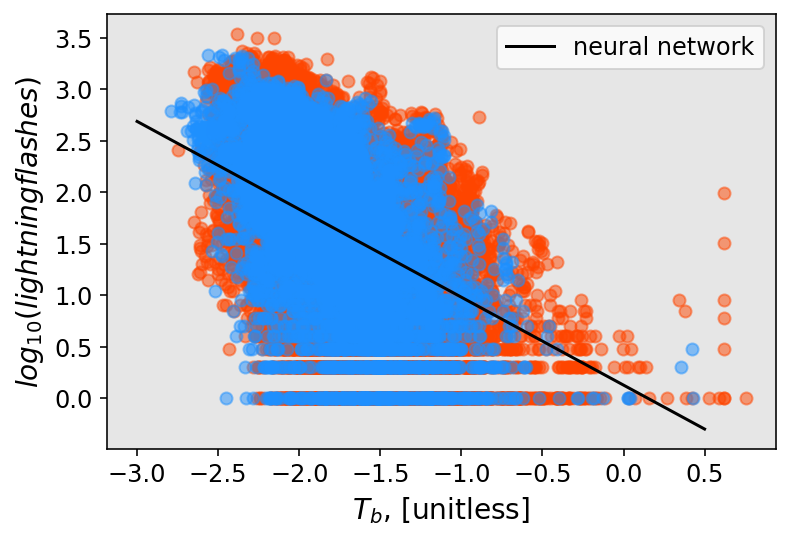

In [17]:
x = np.linspace(-3,0.5)
yhat = model.predict(x)

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.plot(x,yhat,'-k',label='neural network')
plt.legend()
plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')

Not bad! Typically it takes many epochs to train a neural network, but here because the preceptron has only 2 trainable parameters, it doesnt take much to train. Furthermore, this example is basically the same as linear regression which is usually fast to train. 

We can now interogate our model and look at the newly trained parameters!

In [18]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.85252404]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.12982906], dtype=float32)>]

Hopefully you are now a bit more familiar with tensorflow and how it works. These concepts will be further explored and refined in the next example notebooks.